<a href="https://www.nvidia.com/dli"> <img src="images/DLI_Header.png" alt="Header" style="width: 400px;"/> </a>

# Enhancing Data Science Outcomes With Efficient Workflow #

## 01 - Machine Learning Classification Task Primer ##
This lab covers the machine learning model development step of the data science workflow. Model development involves model building, evaluation, fine-tuning, model selection, and model persistence. 

<p><img src='images/pipeline_overview_2.png' width=1080></p>

**Table of Contents**
<br>
In this notebook, we will train a classification model and discuss model evaluation. This notebook covers the below sections: 
1. [Machine Learning Classification Task](#s1-1)
2. [Model Development](#s1-2)
    * [Random Forest](#s1-2.1)
    * [Exercise #1 - Model Evaluation](#s1-e1)
3. [Enhanced Model Evaluation](#s1-3)

<a name='s1-1'></a>
## Machine Learning Classification ##
Classification is a machine learning task that learns how to assign a class label to examples from a domain. Throughout the lab, we will focus on developing a binary classification model, which predicts a given input data as one of two classes. Classification requires a dataset with many examples of inputs and labels from which to train. As the size of the dataset grows, the computation and time required can become a bottleneck for model development. 

<a name='s1-2'></a>
## Model Development ##
We will build a classification model to predict the binary outcome. We break down the procedure into the following steps: 
1. Load data
2. Train model
3. Evaluate

We start by importing data. For this experiment, we will train a [RandomForestClassifier](https://scikit-learn.org/0.17/modules/generated/sklearn.ensemble.RandomForestClassifier.html#sklearn.ensemble.RandomForestClassifier) from [scikit-learn](https://scikit-learn.org/stable/). From the previous exercises, we wrote the processed data into 4 Parquet files. We will load these files in parallel with Dask. Since we are training with the CPU, we will load the data into the host memory with `dask.dataframe.read_parquet()`[[doc]](https://scikit-learn.org/stable/). For comparison, we start with using the original features only. W

In [1]:
# import dependencies
import warnings
warnings.filterwarnings('ignore')

from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve, classification_report, precision_recall_curve, roc_auc_score, confusion_matrix, accuracy_score, f1_score

import dask.dataframe as dd
import matplotlib.pyplot as plt
import time

In [2]:
# specify features list
features_list=['brand', 'cat_0', 'cat_1', 'cat_2', 'cat_3', 
               'price', 'ts_hour', 'ts_minute', 'ts_weekday']

include=features_list+['target']

# read data with Dask
ddf=dd.read_parquet('processed_parquet', columns=include)

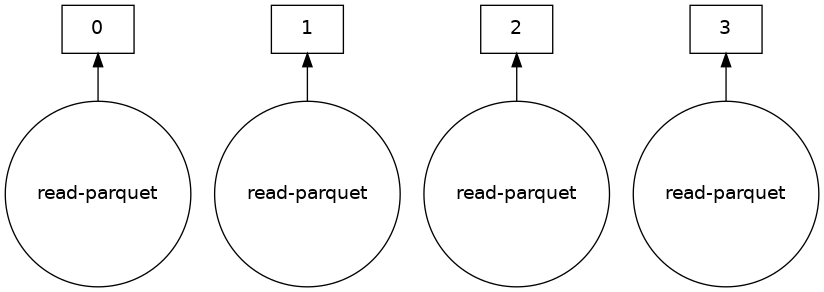

In [3]:
# visualize graph
ddf.visualize()

<p><img src='images/tip.png' width=720></p>
Because the data is likely loaded multiple times during model development and fine-tuning, the Parquet file format offers better data loading performance overall than the CSV file. 

Next, we define the target and features. We will force the data to be loaded into memory with `.compute()`. Data needs to be split into a train and test set, which can be accomplished with `sklearn.model_selection.train_test_split()`[[doc]](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.train_test_split.html#sklearn.model_selection.train_test_split). The train-test split procedure gives us the ability to estimate the performance of machine learning algorithms when they are used to make predictions on data not used to train the model. It is considered a better evaluation. 

In [4]:
# load data in memory
X=ddf[features_list].compute()
y=ddf['target'].compute()

In [5]:
# split data into train and test sets
X_train, X_test, y_train, y_test=train_test_split(X, y, random_state=42)

Next, we will define the classification model. 

<a name='s1-2.1'></a>
### Random Forest ###
The **Random Forest** algorithm is a popular choice for classification and regression problems. It's an ensemble model that trains multiple decision trees and uses a consensus mechanism to make the final prediction. By having multiple trees trained on subsets of the data, it reduces the issue of overfitting with individual decision trees. 

Random forests use the techniques of bagging (bootstrap aggregation) and feature subsampling to make sure that no two resulting decision trees are the same. With bagging, each decision tree is trained upon a different sample of the original dataset. In the bootstrapped dataset, a given sample (row) of the training data can exist multiple times due to replacement. When the algorithm decides on a split during tree building, only a random sample of features (columns) is considered. Feature subsampling can highlight different aspects of the dataset that might go unnoticed if they are overpowered by more prominent features. 

<p><img src='images/random_forest.png' width=720></p>

skikit-learn's `RandomForestClassifier()` supports a number of model parameters: 
* `n_estimators` (default=100): the number of trees in the forest
* `max_depth` (default=None): the maximum depth of the tree
* `min_samples_leaf` (default=1) and `min_samples_split` (default=2): the minimum number of samples required to be a leaf node and split. 

Though we are using the default parameters, we will work to optimize them in the following exercises. 

<p><img src='images/tip.png' width=720></p>

Ensemble methods based on decision tress are popular because they produce good results and can be easily interpreted. 

In [6]:
# initialize classifier
rf=RandomForestClassifier()

In [7]:
# train model
start=time.time()
rf.fit(X_train, y_train)
elapsed_time=time.time()-start

print(f'Training {len(X_train)} samples took {round(elapsed_time/60, 2)} minutes. ')

Training 1846272 samples took 4.95 minutes. 


<p><img src='images/tip.png' width=720></p>

The number of trees and training time are close to linearly correlated. Training 350 trees would likely take - 

In [8]:
# estimate training time
print(f'{round(elapsed_time/100/60*350, 2)} minutes')

17.31 minutes


<a name='s1-e1'></a>
### Exercise #1 - Model Evaluation ###
Once the model has been fitted to the data, we need to evaluate model performance. In addition to model performance, inference performance is also an important consideration. We can use the `.score()`[[doc]](https://scikit-learn.org/stable/modules/generated/sklearn.dummy.DummyClassifier.html#sklearn.dummy.DummyClassifier.score) method to get the overall accuracy score of the model. In addition to model accuracy, we are also interested in the model inference performance, i.e., how many predictions can the model produce. 

**Instructions**: <br>
* Modify the `<FIXME>`s only and execute the below cell to calculate the training and testing accuracy scores. 
* Execute the cell below to calculate the throughput. 

In [9]:
# evaluate model performance
train_score=rf.score(X_train, y_train)
test_score=rf.score(X_test, y_test)

print(f'Train score: {round(train_score, 2)} | Test score: {round(test_score, 2)}')

Train score: 0.97 | Test score: 0.65


Click ... to show **solution**.

In [10]:
# evaluate model inference performance
start=time.time()
prediction_test=rf.predict_proba(X_test)
elapsed_time=time.time()-start

throughput=round(len(X_test)/elapsed_time, 2)
print(f'Throughput is: {throughput} per seconds. ')

Throughput is: 18500.99 per seconds. 


<a name='s1-3'></a>
## Enhanced Model Evaluation ##
Generally, the overall accuracy is not the best measure to determine the performance of classification models, particularly those that are trained with imbalanced or skewed datasets. We saw from the previous exercise that the model suffers from overfitting based on the accuracy score discrepancies between the train and test set. [Precision, recall, and F1 score](https://en.wikipedia.org/wiki/Precision_and_recall) are recommended alternatives to help select the right classification model. The f1 score is the weighted average of precision and recall. 

Furthermore, we can use the [AUC-ROC Curve](https://en.wikipedia.org/wiki/Receiver_operating_characteristic) to calculate the area under the receiver operating characteristic curve from prediction scores. It is used to measure how well a model is capable of distinguishing between classes. This can be done with the `.roc_auc_score()`[[doc]](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.roc_auc_score.html)  function. 

In [ ]:
# get probability of positive class
prediction_proba=prediction_test[:, 1]

# get prediction label if using best threshold
threshold=0.5
prediction_label=(prediction_proba >= threshold).astype('int64')

In [ ]:
# generate classification report and confusion matrix
print("Classification Report: \n", classification_report(y_test, prediction_label))
print("Confusion Matrix: \n", confusion_matrix(y_test, prediction_label))

In [ ]:
# calculate precision, recall, and f1 score
precision, recall, thresholds=precision_recall_curve(y_test, prediction_proba)
f1=f1_score(y_test, prediction_label)

# calculate AUC ROC
auc_roc=roc_auc_score(y_test, prediction_proba)

print(f'F1 Score is {round(f1, 2)}. ')
print(f'Area Under the Receiver Operating Characteristic Curve is {round(auc_roc, 2)}. ')

In [ ]:
# calculate fpr and tpr using sklearn
fpr, tpr, _=roc_curve(y_test, prediction_proba)

# plot ROC
plt.plot(fpr, tpr, label=f'ROC Curve (Area = {round(auc_roc, 2)})')
plt.plot([0, 1], [0, 1], linestyle='--', label='ROC Random')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc='lower right')
plt.show()

<p><img src='images/tip.png' width=720></p>

When calculating various metrics, it's important to understand when `y_score` or `y_pred` should be used. They differ in that `y_score` is the probability estimates `y_pred` is the estimated target labels. 

In [ ]:
# clean GPU memory
import IPython
app = IPython.Application.instance()
app.kernel.do_shutdown(restart=False)

This will serve as the baseline machine learning model. Going forward, we will work towards improving model performance and model inference performance. 

**Well Done!** Let's move to the [next notebook](2_02_accelerated_model_development.ipynb). 

<a href="https://www.nvidia.com/dli"> <img src="images/DLI_Header.png" alt="Header" style="width: 400px;"/> </a>